**ClusterAI 2021** 
<br> **Ciencia de Datos - Ingenieria Industrial UTN BA** 
<br> **Curso I5521** 
<br> **Docente: Martín Palazzo**
<br> **Tutor: Andrés De Leo**
<br> **Proyecto: Análisis de Proyectos de Investigación** 
<br> **Elaborado por: Gastón Rimbano**

# Importamos Librerías

In [1]:
# Dato
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='talk', style='whitegrid')

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

# Otros
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Funciones personalizadas
def best_param_score(reg_gs_cv:GridSearchCV):
    """
    A esta función se le pasa un regresor entrenado usando GriSearchCV
    y devuelve la mejor combinación de parámetros y su puntaje correspondiente.
    
    reg_gs: sklearn.model_selection.GridSearchCV
    Regresor entrenado por GridSearchCV
    """
    print('La mejor combinación de parámetros es: ')
    print(reg_gs_cv.best_params_)
    print()
    print('El mejor puntaje fue ', reg_gs_cv.best_score_)

# Importamos Data Set Pre-Procesado
Procedemos a importar el Data Set que hemos obtenido como resultado de nuestro EDA y Pre-Procesamiento de Datos, y determinaremos las variables a utilizar en nuestro modelo de Machine Learning.

**El objetivo del modelo será predecir mediante una regresión la cantidad de días que dura cada proyecto**

In [3]:
# Importamos Data Set pre-procesado
df_proyectos_pp = pd.read_csv('data/procesada/proyectos_procesado.csv', delimiter= ';', 
                           parse_dates= ['fecha_inicio', 'fecha_finalizacion'])

# Mostramos un head para ver nuestros datos
df_proyectos_pp.head()

,institucion_origen,fecha_inicio,fecha_finalizacion,monto_total_adjudicado,monto_financiado_adjudicado,estado,cantidad_miembros_F,cantidad_miembros_M,sexo_director,area_conocimiento,cantidad_miembros_total,año_inicio,duracion_dias
0,CONICET,2009-01-01,2011-12-31,89850.0,89850.0,Finalizado,3.0,1.0,F,Ciencias Naturales Y Exactas,4.0,2009,1094
1,CONICET,2009-01-01,2011-12-31,180000.0,180000.0,Finalizado,4.0,6.0,F,Ingenierías Y Tecnologías,10.0,2009,1094
2,CONICET,2009-01-01,2011-12-31,90000.0,90000.0,Finalizado,2.0,0.0,M,Ciencias Médicas Y De La Salud,2.0,2009,1094
3,CONICET,2009-01-01,2011-12-31,36000.0,36000.0,Finalizado,1.0,0.0,M,Ciencias Médicas Y De La Salud,1.0,2009,1094
4,CONICET,2009-01-01,2011-12-31,24000.0,24000.0,Finalizado,0.0,2.0,M,Ciencias Médicas Y De La Salud,2.0,2009,1094


Mostramos los nombres de nuestras columnas y un detalle rápido del Data Set

In [4]:
print(df_proyectos_pp.columns.values)
print('_'*100)
display(df_proyectos_pp.info())

['institucion_origen' 'fecha_inicio' 'fecha_finalizacion'
 'monto_total_adjudicado' 'monto_financiado_adjudicado' 'estado'
 'cantidad_miembros_F' 'cantidad_miembros_M' 'sexo_director'
 'area_conocimiento' 'cantidad_miembros_total' 'año_inicio'
 'duracion_dias']
____________________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11672 entries, 0 to 11671
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   institucion_origen           11672 non-null  object        
 1   fecha_inicio                 11672 non-null  datetime64[ns]
 2   fecha_finalizacion           11672 non-null  datetime64[ns]
 3   monto_total_adjudicado       11672 non-null  float64       
 4   monto_financiado_adjudicado  11672 non-null  float64       
 5   estado                       11672 non-null  object        
 6   can

None

Veamos la cantidad de registros de cada **estado** que tenemos.

In [5]:
df_proyectos_pp.estado.value_counts()

Finalizado      11420
En ejecución      252
Name: estado, dtype: int64

Para el objetivo de nuestro modelo, **debemos trabajar solo con proyectos que tengan como estado 'Finalizado'**.

Una vez filtrado, ya no necesitaremos esta columna, como tampoco son necesarias las columnas **fecha_inicio** y **fecha_finalización**, ya que tenemos la columnas **duracion_dias**. La columna **año_inicio** era necesaria para el EDA, pero ya no más para nuestro modelo.

Crearemos un nuevo Data Set sobre el que aplicaremos todas estas transformaciones, y lo llamaremos **df_proyectos_ml**.

In [6]:
# Creamos un nuevo Data Set, el cual es el Data Set Pre-Procesado
# filtrado por aquellos proyectos que tienen como estado 'Finalizado'
df_proyectos_ml = df_proyectos_pp[df_proyectos_pp.estado == 'Finalizado']

# Definimos las columnas a eliminar y las eliminamos
columnas_eliminar = ['fecha_inicio', 'fecha_finalizacion', 'estado', 'año_inicio']
df_proyectos_ml.drop(columns=columnas_eliminar, axis=1, inplace= True)

# Mostramos el nuevo aspecto de nuestros datos
print('La forma de nuestro nuevo Data Set es: ', df_proyectos_ml.shape )
df_proyectos_ml.head()

La forma de nuestro nuevo Data Set es:  (11420, 9)


,institucion_origen,monto_total_adjudicado,monto_financiado_adjudicado,cantidad_miembros_F,cantidad_miembros_M,sexo_director,area_conocimiento,cantidad_miembros_total,duracion_dias
0,CONICET,89850.0,89850.0,3.0,1.0,F,Ciencias Naturales Y Exactas,4.0,1094
1,CONICET,180000.0,180000.0,4.0,6.0,F,Ingenierías Y Tecnologías,10.0,1094
2,CONICET,90000.0,90000.0,2.0,0.0,M,Ciencias Médicas Y De La Salud,2.0,1094
3,CONICET,36000.0,36000.0,1.0,0.0,M,Ciencias Médicas Y De La Salud,1.0,1094
4,CONICET,24000.0,24000.0,0.0,2.0,M,Ciencias Médicas Y De La Salud,2.0,1094


Nos aseguramos que nuestro Data Set no tenga ningún registro Nulo

In [7]:
df_proyectos_ml.isna().any()

institucion_origen             False
monto_total_adjudicado         False
monto_financiado_adjudicado    False
cantidad_miembros_F            False
cantidad_miembros_M            False
sexo_director                  False
area_conocimiento              False
cantidad_miembros_total        False
duracion_dias                  False
dtype: bool

Como vemos, nuestro Data Set no tiene ningún registro nulo, ya que nos hemos encargado de eliminar todos durante el Pre-Procesamiento de datos.

# Generamos X e Y para nuestro Modelo
Como es sabido nuestra **Y** será la columna **duracion_dias**. Para nuestro modelo tomaremos como **X** a todas las columnas disponibles, excepto **cantidad_miembros_F** y **cantidad_miembros_M**, ya que utilizaremos simplemente **cantidad_miembros_total**.

## Descomponemos el Data Set en 'features' y 'target'

In [9]:
# Generamos una lista con los nombres de todas las columans
column_names = df_proyectos_ml.columns.values

# Generamos una tupla con las columnas a excluir
excluded_columns = ('cantidad_miembros_F', 'cantidad_miembros_M')

# Generamos una lista con el nombre de la columna objetivo
target_name = ['duracion_dias']

# Generamos una lista con el nombre de las columnas que utilizaremos como features
features_name = [i_c for i_c in column_names if i_c not in (excluded_columns + tuple(target_name) )]

# Generamos un Data Frame con las columnas que utilizaremos como features
features = df_proyectos_ml[features_name]

# Generamos un Data Frame con la columna que utilizaremos como target
target = df_proyectos_ml[target_name]

# Informamos nuestras features y su aspecto
print('Las features serán: ', features_name)
print('Su forma inicial es: ', features.shape)

print()

# Informamos nuestro target y su aspecto
print('El target será: ', target_name)
print('Su forma es: ', target.shape)

Las features serán:  ['institucion_origen', 'monto_total_adjudicado', 'monto_financiado_adjudicado', 'sexo_director', 'area_conocimiento', 'cantidad_miembros_total']
Su forma inicial es:  (11420, 6)

El target será:  ['duracion_dias']
Su forma es:  (11420, 1)


## Generamos Dummies para Variables Categóricas
Debido a que tenemos columnas con variables categóricas, debemos generar Dummies. Esto quiere decir que agregaremos una columna para cada valor único de cada variable categórica, donde se indicará un '1' si el registro tiene el valor de la columnas correspondiente, o un '0' si no lo tiene

In [10]:
# Obtenemos el nombre de las columnas categóricas
cat_var_columns = features.select_dtypes(['object']).columns.values

# Generamos dummies sobre nuestro Data Frame de features, indicando las columnas categóricas
features = pd.get_dummies(data=features, columns= cat_var_columns)

# Mostramos como luce el Data Frame de features luego de generar dummies
print('La nueva forma de nuestro set de features es: ', features.shape)
features.head()

La nueva forma de nuestro set de features es:  (11420, 14)


,monto_total_adjudicado,monto_financiado_adjudicado,cantidad_miembros_total,institucion_origen_ANPCYT,institucion_origen_CONICET,institucion_origen_INTA,sexo_director_F,sexo_director_M,area_conocimiento_Ciencias Agrícolas,area_conocimiento_Ciencias Médicas Y De La Salud,area_conocimiento_Ciencias Naturales Y Exactas,area_conocimiento_Ciencias Sociales,area_conocimiento_Humanidades,area_conocimiento_Ingenierías Y Tecnologías
0,89850.0,89850.0,4.0,0,1,0,1,0,0,0,1,0,0,0
1,180000.0,180000.0,10.0,0,1,0,1,0,0,0,0,0,0,1
2,90000.0,90000.0,2.0,0,1,0,0,1,0,1,0,0,0,0
3,36000.0,36000.0,1.0,0,1,0,0,1,0,1,0,0,0,0
4,24000.0,24000.0,2.0,0,1,0,0,1,0,1,0,0,0,0


Como vemos, luego de generar Dummies, tenemos más del doble de columnas.

## Creamos X e Y
Ahora que nuestros Data Frame de **features** y **target** tienen su aspecto final, procedemos a **asignar sus valores a X e Y respectivamente**.

In [11]:
X = features.values
Y = target.values

print('La forma de nuestra X es:', X.shape)
print('La forma de nuestra Y es:', Y.shape)

La forma de nuestra X es: (11420, 14)
La forma de nuestra Y es: (11420, 1)


## Veamos un HeatMap de nuestras Features

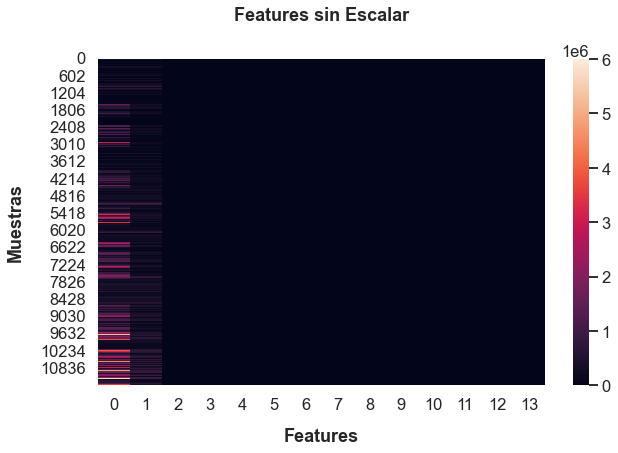

In [14]:
# Definimos el tamaño de nuestro gráfico
plt.figure(figsize=(10,6))

# Generamos el heatmap de nuestro conjunto de datos de features (X)
sns.heatmap(X)

# Ponemos títulos y etiquetas de ejes a nuestro gráfico
plt.title('Features sin Escalar', y=1.1, fontweight='bold')
plt.xlabel('Features', fontweight='bold', labelpad=15)
plt.ylabel('Muestras', fontweight='bold', labelpad=15)

# Guardamos el gráfico
plt.savefig('graphics/heatmap_features_sin_escalar.png', bbox_inches='tight')
plt.show()

Como podemos ver, **necesitamos aplicar un Escaler sobre nuestros datos**.

Veamos ahora nuevamente el **heatmap de correlación de nuestras Features**

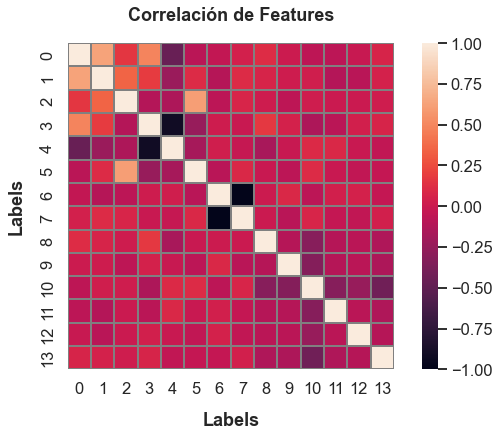

In [15]:
# Definimos el tamaño de nuestro gráfico
plt.figure(figsize=(10,6))

# Generamos el heatmap de correlación de nuestras features
sns.heatmap(pd.DataFrame(X).corr(), square=True, linecolor='grey', linewidths=2)

# Ponemos títulos y etiquetas de ejes a nuestro gráfico
plt.title('Correlación de Features', fontweight='bold', y=1.05)
plt.xlabel('Labels', labelpad=15, fontweight='bold')
plt.ylabel('Labels', labelpad=15, fontweight='bold')

# Guardamos el gráfico
plt.savefig('graphics/heatmap_correlacion_features.png', bbox_inches='tight')
plt.show()

Como vemos, salvo las **Features 0 y 1**, el resto no parece tener correlación.

La **Feature 10** parece ser bastante **ortogonal** al resto de las features cercanas.

# Pre-Procesamiento de Datos para Modelo de ML
En esta sección procederemos a dividir nuestra X e Y en particiones de Train y Test. Luego "aprenderemos" un escaler con los datos de las features de train y los transformaremos, como así también a los de test utilizando el mismo escaler.

## Dividimos el Data Set en  Train & Test

In [18]:
# Partimos nuestros registros de features y target en train y test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=10)

# Mostramos el aspecto de los datos de train
print('La forma de x_train es: ', x_train.shape)
print('La forma de y_train es: ', y_train.shape)

print()

# Mostramos el aspecto de los datos de test
print('La forma de x_test es: ', x_test.shape)
print('La forma de y_test es: ', y_test.shape)

La forma de x_train es:  (8565, 14)
La forma de y_train es:  (8565, 1)

La forma de x_test es:  (2855, 14)
La forma de y_test es:  (2855, 1)


## Escalamos nuestros Datos usando Standard Scaler
Esto lo haremos únicamente sobre nuestras variables numéricas, y no sobre los Dummies que hemos generado, por lo cual procederemos a entrenar un scaler solo sobre estas columnas de train.

In [19]:
# Generamos un escaler y lo ajustamos a nuestros 
# datos de train de features numéricas originales
std_scaler = StandardScaler()
std_scaler.fit(x_train[:,:3])

# Aplicamos el escaler sobre las features numéricas originales del set de train
# y le agregamos las features correspondientes a los dummies generados
x_tr_ss = std_scaler.transform(x_train[:,:3])
x_tr_ss = np.concatenate( (x_tr_ss, x_train[:, 3:]) , axis=1 )

# Aplicamos el escaler sobre las features numéricas originales del set de test
# y le agregamos las features correspondientes a los dummies generados
x_te_ss = std_scaler.transform(x_test[:,:3])
x_te_ss = np.concatenate( (x_te_ss, x_test[:, 3:]) , axis=1 )

Ahora que tenemos los datos escalados, volvemos a ver un **Heat Map**

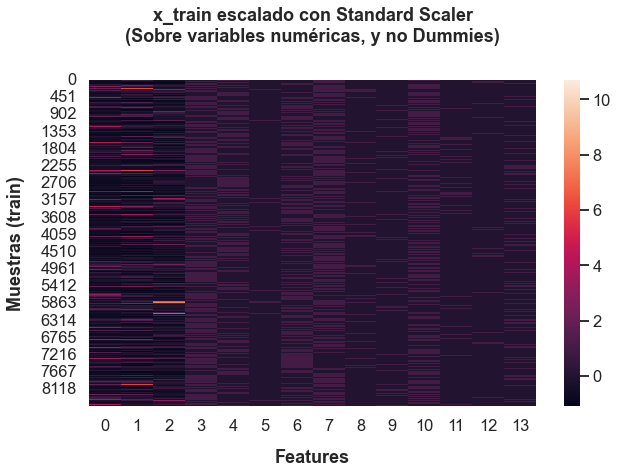

In [20]:
# Definimos el tamaño de nuestro gráfico
plt.figure(figsize=(10,6))

# Generamos el heatmap de nuestro conjunto de datos de features (X)
sns.heatmap(x_tr_ss)

# Ponemos títulos y etiquetas de ejes a nuestro gráfico
plt.title('x_train escalado con Standard Scaler\n(Sobre variables numéricas, y no Dummies)',
          y=1.1, fontweight='bold')
plt.xlabel('Features', fontweight='bold', labelpad=15)
plt.ylabel('Muestras (train)', fontweight='bold', labelpad=15)

# Guardamos el gráfico
plt.savefig('graphics/heatmap_features_escaladas.png', bbox_inches='tight')
plt.show()

Esto tiene mucho mejor aspecto que lo que habíamos visto anteriormente.

# Modelos Lineales
En esta sección plantearemos y entrenaremos modelos lineales. Los modelos a utilizar son:
- Regresión Lineal
- Regresión de Ridge
- Regresión de Lasso
- Regresión Lineal con Regularización Elasticnet

En todos los casos procederemos a generar el regresor, establecer parámetros que validaremos utilizando **GridSearchCV**, entrenar el regresor, analizar parámetros óptimos y su score y, finalmente, predecir los y^ (hat) de los valores correspondientes a test.

## Regresión Lineal Simple
Se trata de un modelo de **Regresión Lineal por Mínimos Cuadrados ordinaria**. 

La Regresión Lineal Simple se ajusta a un modelo lineal con coeficientes $w = (w1,…, wp)$ para minimizar la suma de los residuos al cuadrado, entre los valores de target reales y los predichos por el modelo.

Los parámetros a validar en Grid Search serán:
- 'fil_intercept'
- 'copy_X'

In [21]:
# Definimos el modelo
lin = LinearRegression()

# Establecemos los parámetros a validar en el GridSearchCV
lin_param = {'fit_intercept':[True,False], 'copy_X':[True, False]}

# Configuramos el GridSearchCV para el regresor
lin_reg = GridSearchCV(lin, lin_param, refit=True, cv=5, verbose=True)

In [22]:
# Entrenamos nuestro modelo con los datos de train
lin_reg.fit(x_tr_ss, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             verbose=True)

In [23]:
# Informamos los parámetros que presentaron el mejor score y su valor
best_param_score(lin_reg)

La mejor combinación de parámetros es: 
{'copy_X': True, 'fit_intercept': True}

El mejor puntaje fue  0.4614944480788495


In [24]:
# Predecimos los valores de nuestros target en el set de test
yte_hat_lin = lin_reg.predict(x_te_ss)

## Regresión de Ridge
**Se trata de una Regresión Lineal de Mínimos Cuadrados con una Regularización l2.** Minimiza la función objetivo: $$||y - Xw||^2_{  2} + alpha * ||w||^2_{  2}$$

Este modelo **resuelve un modelo de regresión donde la función de pérdida es la función de mínimos cuadrados lineales y la regularización viene dada por la norma l2**. También conocido como Regresión de Ridge o regularización de Tikhonov.

Los parámetros a validar en Grid Search serán:
- 'alpha'
- 'fit_intercept'
- 'copy_X'
- 'solver'
- 'positive'

In [167]:
# Definimos el modelo
ridge = Ridge()

# Establecemos los parámetros a validar en el GridSearchCV
ridge_param = {'alpha': [0.1, 0.5, 1], 'fit_intercept': [True, False], 'copy_X': [True, False], 
               'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'], 
               'positive': [True, False]
              }

# Configuramos el GridSearchCV para el regresor
ridge_reg = GridSearchCV(ridge, ridge_param, refit=True, cv=5, verbose=True)

In [168]:
# Entrenamos nuestro modelo con los datos de train
ridge_reg.fit(x_tr_ss, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 0.5, 1], 'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'positive': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga', 'lbfgs']},
             verbose=True)

In [169]:
# Informamos los parámetros que presentaron el mejor score y su valor
best_param_score(ridge_reg)

La mejor combinación de parámetros es: 
{'alpha': 1, 'copy_X': False, 'fit_intercept': True, 'positive': False, 'solver': 'saga'}

El mejor puntaje fue  0.46140891869985834


In [170]:
# Predecimos los valores de nuestros target en el set de test
yte_hat_ridge = ridge_reg.predict(x_te_ss)

## Regresión de Lasso
**Modelo lineal entrenado con prior L1 como regularizador (también conocido como Lasso)**. El objetivo de optimización de Lasso es: $$(1 / (2 * n_{samples}))) * ||y - Xw||^2_2 + alpha * ||w||_1$$

Técnicamente, el modelo Lasso está optimizando la misma función objetivo que **Elastic Net con l1_ratio = 1.0 (sin penalización L2)**.

Los parámetros a validar en Grid Search serán:
- 'alpha'
- 'fit_intercept'
- 'copy_X'
- 'positive'

In [177]:
# Definimos el modelo
lasso = Lasso()

# Establecemos los parámetros a validar en el GridSearchCV
lasso_param = {'alpha': [0.1, 0.5, 1], 'fit_intercept': [True, False],   
               'copy_X': [True, False], 'positive': [True, False]}

# Configuramos el GridSearchCV para el regresor
lasso_reg = GridSearchCV(lasso, lasso_param, refit=True, cv=5, verbose=True)

In [178]:
# Entrenamos nuestro modelo con los datos de train
lasso_reg.fit(x_tr_ss, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.1, 0.5, 1], 'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'positive': [True, False]},
             verbose=True)

In [179]:
# Informamos los parámetros que presentaron el mejor score y su valor
best_param_score(lasso_reg)

La mejor combinación de parámetros es: 
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'positive': False}

El mejor puntaje fue  0.461443705675158


In [180]:
# Predecimos los valores de nuestros target en el set de test
yte_hat_lasso = lasso_reg.predict(x_te_ss)

## Regresión Lineal con Regularización Elastic Net
**Regresión Lineal con priors L1 y L2 combinados como Regularizadores.** Minimiza la función objetivo:

$$1 / (2 * n_{samples}) * ||y - Xw||^2_2 + alpha * l1_{ratio} * ||w||_1 + 0.5 * alpha * (1 - l1_{ratio}) * ||w||^2_2$$

Si uno está interesado en controlar la penalización L1 y L2 por separado, debe tener en cuenta que esto es equivalente a: $$a * ||w||_1 + 0.5 * b * ||w||_2^2$$ 
donde 
$$alpha = a + b$$$$l1_{ratio} = a / (a + b)$$

Específicamente, 'l1_ratio = 1' es equivalente a la penalización del Lasso.

<br>


Los parámetros a validar en Grid Search serán:
- 'alpha'
- 'fit_intercept'
- 'copy_X'
- 'positive'

In [184]:
# Definimos el modelo
elastic = ElasticNet()

# Establecemos los parámetros a validar en el GridSearchCV
elastic_param = {'alpha': [0, 0.25, 0.5], 'fit_intercept': [True, False],   
               'copy_X': [True, False], 'positive': [True, False]}

# Configuramos el GridSearchCV para el regresor
elastic_reg = GridSearchCV(elastic, elastic_param, refit=True, cv=5, verbose=True)

In [185]:
# Entrenamos nuestro modelo con los datos de train
elastic_reg.fit(x_tr_ss, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0, 0.25, 0.5], 'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'positive': [True, False]},
             verbose=True)

In [186]:
# Informamos los parámetros que presentaron el mejor score y su valor
best_param_score(elastic_reg)

La mejor combinación de parámetros es: 
{'alpha': 0, 'copy_X': True, 'fit_intercept': True, 'positive': False}

El mejor puntaje fue  0.46139645525048956


In [187]:
# Predecimos los valores de nuestros target en el set de test
yte_hat_elastic = elastic_reg.predict(x_te_ss)

**Como vemos, el score (R2) de todos los modelos es muy similar, y ronda el 0,4614 para nuestro Data Set**

**El mejor modelo dentro de todos los Modelos Lineales resultó ser la Regresión Lineal Simple**

# KNN Regressor
Se trata de una **regresión basada en k-vecinos más cercanos. La variable objetivo se predice mediante la interpolación local de los targets asociados a los vecinos más cercanos en el conjunto de entrenamiento**.

El procedimiento a aplicar es el mismo que hemos explicado al comienzo de Métodos Lineales.

Los parámetros a validar en Grid Search son:
- 'n_neighbors'
- 'weights'
- 'algorithm'
- 'p'

In [205]:
# Definimos el modelo
knn = KNeighborsRegressor()

# Establecemos los parámetros a validar en el GridSearchCV
knn_param = {'n_neighbors': range(25,36,1), 'weights': ['uniform', 'distance'], 
             'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [1,2]}

# Configuramos el GridSearchCV para el regresor
knn_reg = GridSearchCV(knn, knn_param, refit= True, cv=5, verbose=True)

In [206]:
# Entrenamos nuestro modelo con los datos de train
knn_reg.fit(x_tr_ss, y_train)

Fitting 5 folds for each of 176 candidates, totalling 880 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(25, 36), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=True)

In [207]:
# Informamos los parámetros que presentaron el mejor score y su valor
best_param_score(knn_reg)

La mejor combinación de parámetros es: 
{'algorithm': 'auto', 'n_neighbors': 28, 'p': 1, 'weights': 'distance'}

El mejor puntaje fue  0.5415869020005554


In [210]:
# Predecimos los valores de nuestros target en el set de test
yte_hat_knn = knn_reg.predict(x_te_ss)

**El score (R2) del KNN Regressor es bastante mejor que el que hemos obtenido con los Modelos Lineales** 

**0.5416  vs  0,4614**

# Suport Vector Regression (SVR)
Se trata de una **regresión vectorial con soporte de épsilon. Los parámetros libres en el modelo son C y épsilon. La complejidad del tiempo de ajuste es más que cuadrática con el número de muestras, lo que dificulta escalar a conjuntos de datos con más de 10000 muestras.**

El procedimiento a aplicar es el mismo que hemos explicado al comienzo de Métodos Lineales.

Los parámetros a validar en Grid Search son:
- 'kernel'
- 'C'
- 'gamma'

In [246]:
# Definimos el modelo
svr = SVR()

# Establecemos los parámetros a validar en el GridSearchCV
svr_param = {'kernel':('linear', 'rbf'), 'C':[100, 200, 500 ], 'gamma':[ 0.1,1]}

# Configuramos el GridSearchCV para el regresor
svr_reg = GridSearchCV(svr, svr_param, refit= True, cv=3, verbose=True)

In [247]:
# Entrenamos nuestro modelo con los datos de train
svr_reg.fit(x_tr_ss, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [100, 200, 500], 'gamma': [0.1, 1],
                         'kernel': ('linear', 'rbf')},
             verbose=True)

Tal como comentamos más arriba, este modelo tardó sustancialmente más tiempo que los que hemos entrenado hasta ahora.

In [248]:
# Informamos los parámetros que presentaron el mejor score y su valor
best_param_score(svr_reg)

La mejor combinación de parámetros es: 
{'C': 500, 'gamma': 1, 'kernel': 'rbf'}

El mejor puntaje fue  0.387586258492518


In [249]:
# Predecimos los valores de nuestros target en el set de test
yte_hat_svr = svr_reg.predict(x_te_ss)

**El score (R2) del SVR es inferior al que hemos obenido con el KNN Regressor y con los Modelos Lineales** 

**Modelos Lineales: 0,4614  vs  SVR: 0,3876** 

**KNN Regressor: 0,5416  vs  SVR: 0,3876**

# Random Forest Regression
Un Random Forest **es un meta-estimador que se ajusta a una serie de árboles de decisión de clasificación en varias submuestras del conjunto de datos y utiliza promedios para mejorar la precisión predictiva y controlar el sobreajuste.**

El procedimiento a aplicar es el mismo que hemos explicado al comienzo de Métodos Lineales.

Los parámetros a validar en Grid Search son:
- 'n_estimators'
- 'criterion'
- 'max_features'
- 'min_samples_leaf'

In [266]:
# Definimos el modelo
rf = RFR()

# Establecemos los parámetros a validar en el GridSearchCV
rf_param = {'n_estimators': [50,70,100], 
            'criterion': ['squared_error'],
            'max_features': ['auto'],  
            'min_samples_leaf': [5, 10, 15]}

# Configuramos el GridSearchCV para el regresor
rf_reg = GridSearchCV(rf, rf_param, refit= True, cv=5, verbose=True)

In [267]:
# Entrenamos nuestro modelo con los datos de train
rf_reg.fit(x_tr_ss, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error'],
                         'max_features': ['auto'],
                         'min_samples_leaf': [5, 10, 15],
                         'n_estimators': [50, 70, 100]},
             verbose=True)

In [268]:
# Informamos los parámetros que presentaron el mejor score y su valor
best_param_score(rf_reg)

La mejor combinación de parámetros es: 
{'criterion': 'squared_error', 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 70}

El mejor puntaje fue  0.6373168628585006


In [272]:
# Predecimos los valores de nuestros target en el set de test
yte_hat_rf = rf_reg.predict(x_te_ss)

**El score (R2) del Random Forest Regressor es mejor que el de KNN Regressor** 

**0,6373  vs  0,5416**

# Multi-Layer Perceptron Regressor (MLP)
Este modelo **optimiza el error al cuadrado usando LBFGS (método de optimización quasi-Newton de funciones con un gran número de parámetros o de una gran complejidad) o descenso de gradiente estocástico.**

**El Multi-Layer Perceptron Regressor entrena iterativamente ya que en el paso de cada época se calculan las derivadas parciales de la función de pérdida con respecto a los parámetros del modelo para actualizar los parámetros. También se puede agregar un término de regularización a la función de pérdida que reduce los parámetros del modelo para evitar el sobreajuste.**

El procedimiento a aplicar es el mismo que hemos explicado al comienzo de Métodos Lineales.

Los parámetros a validar en Grid Search son:
- 'hidden_layer_sizes'
- 'activation'
- 'solver'
- 'batch_size'
- 'learning_rate_init'
- 'early_stopping'

In [299]:
# Definimos el modelo
mlp = MLPRegressor()

# Establecemos los parámetros a validar en el GridSearchCV
mlp_param = {'hidden_layer_sizes': [(14,7), (10,5)], 'activation': ['relu'], 
             'solver': ['lbfgs', 'adam'], 'batch_size': [125, 150, 175], 
             'learning_rate_init': [0.02, 0.025, 0.03], 'early_stopping': [True]}

# Configuramos el GridSearchCV para el regresor
mlp_reg = GridSearchCV(mlp, mlp_param, refit= True, cv=3, verbose=True)

In [300]:
# Entrenamos nuestro modelo con los datos de train
mlp_reg.fit(x_tr_ss, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=MLPRegressor(),
             param_grid={'activation': ['relu'], 'batch_size': [125, 150, 175],
                         'early_stopping': [True],
                         'hidden_layer_sizes': [(14, 7), (10, 5)],
                         'learning_rate_init': [0.02, 0.025, 0.03],
                         'solver': ['lbfgs', 'adam']},
             verbose=True)

In [301]:
# Informamos los parámetros que presentaron el mejor score y su valor
best_param_score(mlp_reg)

La mejor combinación de parámetros es: 
{'activation': 'relu', 'batch_size': 175, 'early_stopping': True, 'hidden_layer_sizes': (14, 7), 'learning_rate_init': 0.02, 'solver': 'lbfgs'}

El mejor puntaje fue  0.5588084226104312


In [302]:
# Predecimos los valores de nuestros target en el set de test
yte_hat_mlp = mlp_reg.predict(x_te_ss)

**El score (R2) del Multi-Layer Perceptron es similar al de KNN Regressor, e inferior al de Random Forest Regressor** 

**KNN Regressor: 0,5416  vs  MLP: 0,5588**

**Random Forest Regressor: 0,6373  vs  MLP: 0,5588** 

# Comparando Modelos
Ya hemos analizado el score (R2) que nuestros modelos han presentado durante su entrenamiento (conjunto de train). Ahora **debemos comparar sus resultados al predecir muestras que nunca habían visto**, es decir, al aplicarlo sobre nuestro conjunto de test. De esta manera **podremos verificar si aquellos modelos que mostraron un score más alto en el entrenamiento, también consiguen tener una buena performance en el test. Si esto no es así, significará que estamos ante un modelo sobre-ajustado.**

Lo que haremos será **calcular el MSE (Mean Squared Error) para cada modelo** y luego mostraremos unas gráficas que compararán el valor real con el valor estimado por cada modelo.

In [303]:
# medimos el MSE de la prediccion de cada modelo
mse_lin = mean_squared_error(yte_hat_lin, y_test)
mse_ridge = mean_squared_error(yte_hat_ridge, y_test)
mse_lasso = mean_squared_error(yte_hat_lasso, y_test)
mse_elastic = mean_squared_error(yte_hat_elastic, y_test)
mse_knn = mean_squared_error(yte_hat_knn, y_test)
mse_svr = mean_squared_error(yte_hat_svr, y_test)
mse_rf = mean_squared_error(yte_hat_rf, y_test)
mse_mlp = mean_squared_error(yte_hat_mlp, y_test)

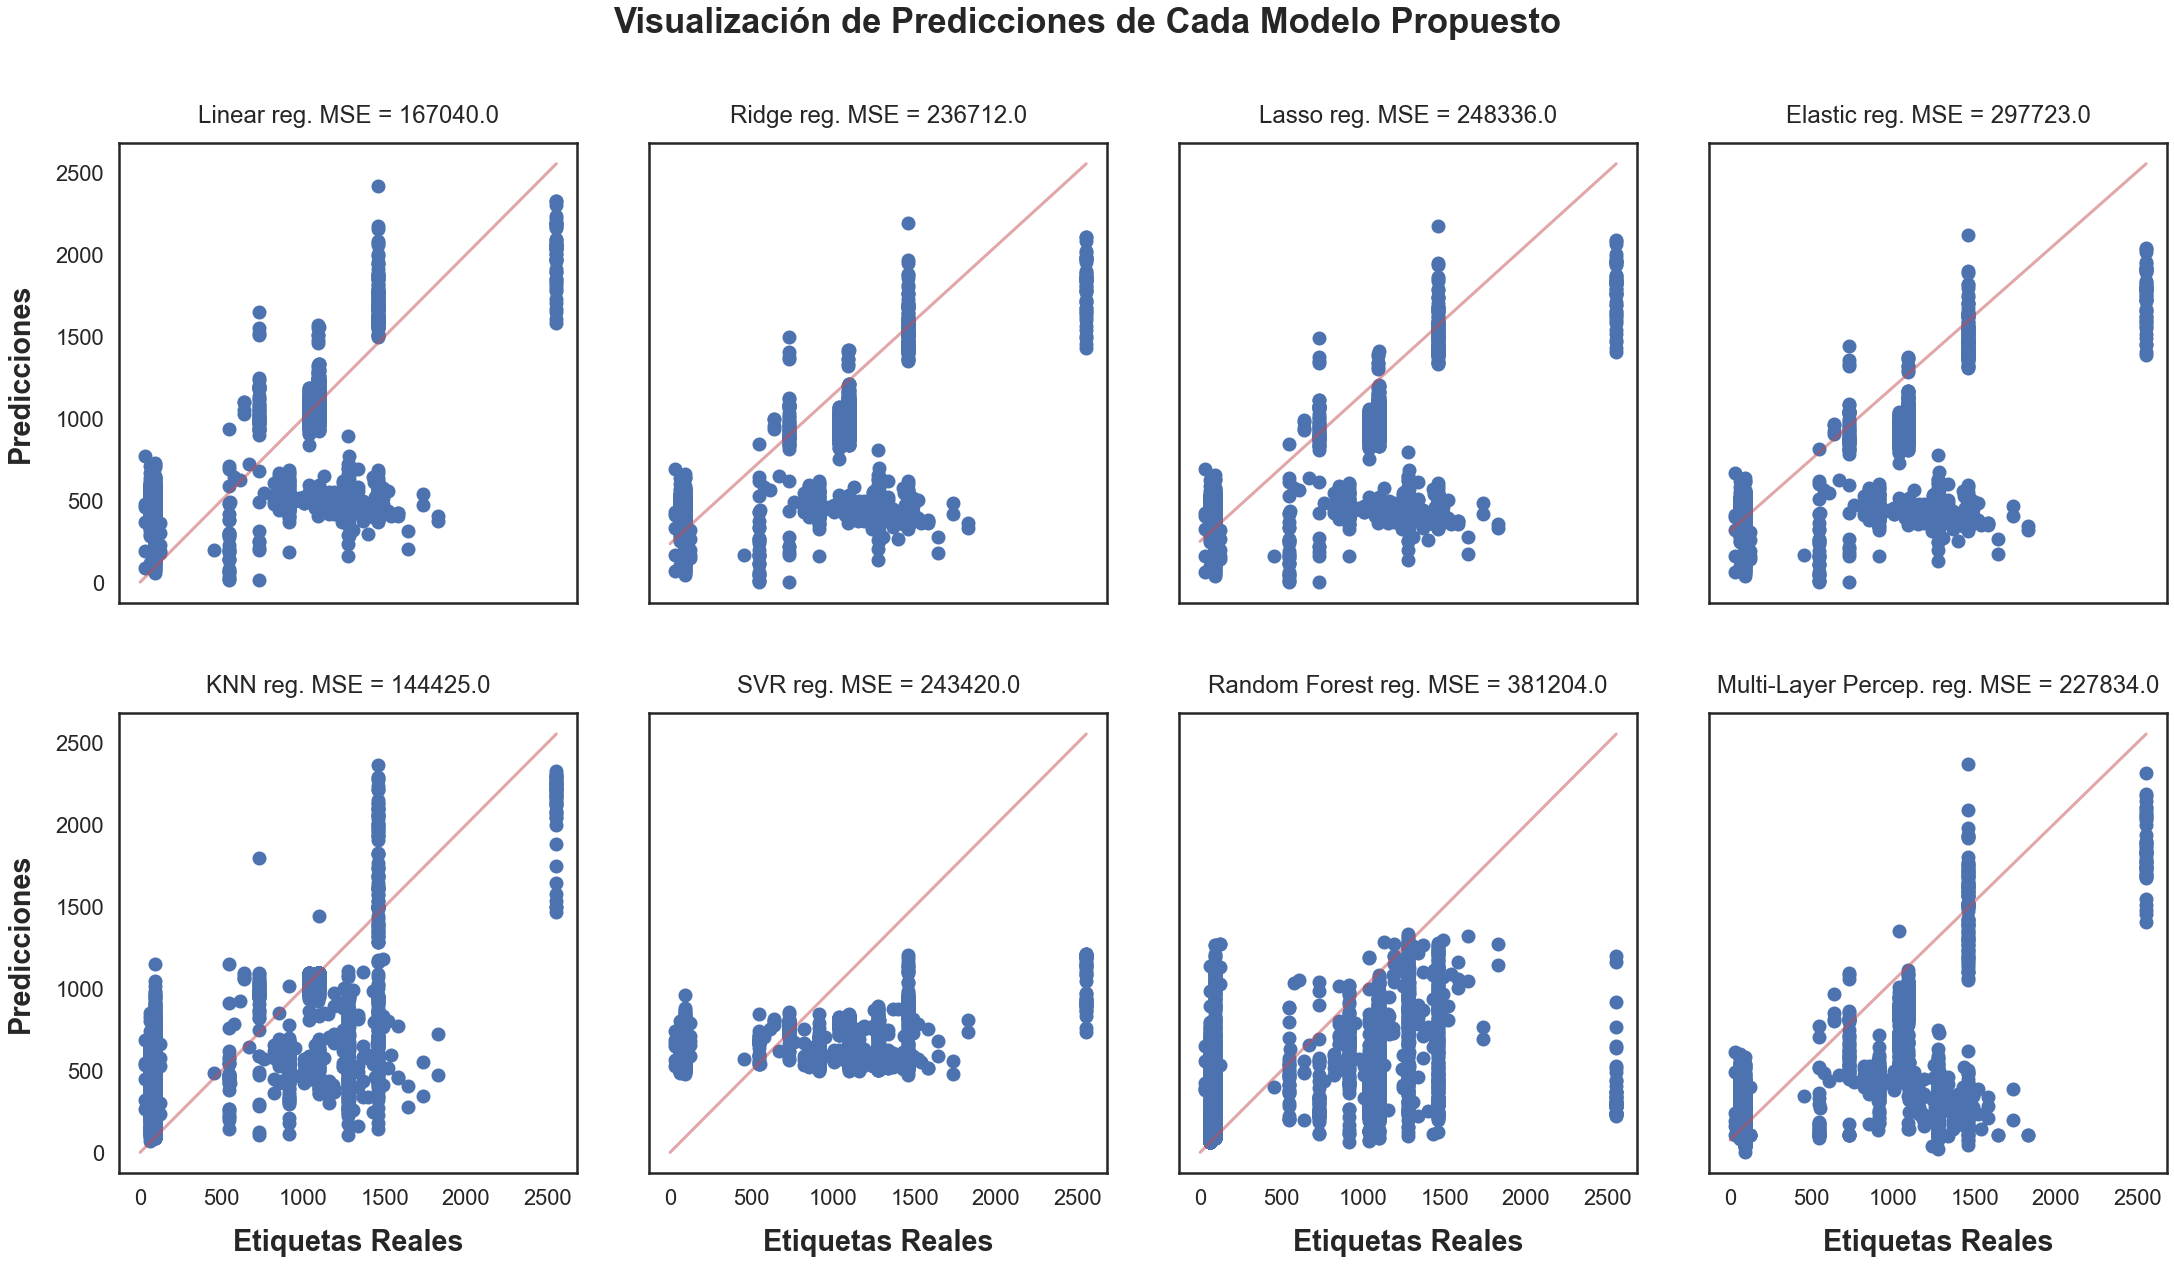

In [351]:
# Generamos una tupla con el nombre de todos nuestros modelos
# Esto lo aplicaremos en los títulos de cada gráfico
modelos = ('Linear', 'Ridge', 'Lasso', 'Elastic', 
           'KNN', 'SVR', 'Random Forest', 'Multi-Layer Percep.')

# Generamos una tupla de los valores predichos por cada modelo
yte_hat = (yte_hat_lin, yte_hat_ridge, yte_hat_lasso, yte_hat_elastic,
          yte_hat_knn, yte_hat_svr, yte_hat_rf, yte_hat_mlp)

# Generamos una tupla de los resultado de MSE que hemos calculado para cada modelo
MSEs = (mse_lin, mse_ridge, mse_lasso, mse_elastic, mse_knn, mse_svr, mse_rf, mse_mlp)

# Configuraciones generales del gráfico
sns.set(context="poster", style='white')
pad = 20

# Generamos un Subplot para poder ver los gráficos en simultáneo
fig, axs = plt.subplots(2,4, figsize = (32,18))

# Ploteamos las predicciones de cada modelo
i = 0
for r in range(axs.shape[0]):
    for c in range(axs.shape[1]):
        # Generamos el scatter con los valores de nuestros target de test
        # y los valores predichos por el modelo en cuestión
        axs[r][c].scatter(y_test, yte_hat[i])
        
        # Generamos una recta en rojo, que marca la diagonal de correspondencia
        # entre los valores reales del target y los valores predichos por el modelo
        axs[r][c].plot(np.arange(np.max(y_test)), np.arange(np.max(y_test)), 
                       color = 'r', alpha = 0.5)
        
        # Generamos el título del gráfico, indicando el nombre del modelo y su MSE
        title_i = modelos[i] + ' reg. MSE = ' +  str(np.round(MSEs[i],0))
        axs[r][c].set_title(title_i, pad=pad)
        
        # Configuramos Ejes y para que solo muestren etiquetas
        # y escala en la primer columna de gráficos
        if c == 0:
            axs[r][c].set_ylabel('Predicciones', labelpad=pad, 
                                 fontweight='bold', fontsize='large')
        else:
            axs[r][c].get_yaxis().set_visible(False)
        
        # Configuramos Ejes x para que solo muestren etiquetas
        # y escala en la última fila de gráficos
        if r == (axs.shape[0]-1):
            axs[r][c].set_xlabel('Etiquetas Reales', labelpad=pad, 
                                 fontweight='bold', fontsize='large')
        else:
            axs[r][c].get_xaxis().set_visible(False)
        
        i += 1

# Configuramos la separación entre gráficos
fig.tight_layout(pad=3)

# Configuramos un título general para los gráficos
fig.suptitle('Visualización de Predicciones de Cada Modelo Propuesto', 
             ha='center', va='baseline', y=1, fontweight='bold', fontsize='x-large')

# Guardamos el gráfico
plt.savefig('graphics/comparando_modelos_regresion.png', bbox_inches='tight')
plt.show()

Si recordamos de **cuando entrenamos** nuestros modelos, el que **mejor score (R2)** arrojó fue el **Random Forest Regressor**. Sin embargo, si observamos la gráfica de la celda anterior, podemos notar que **este modelo no es el que presenta mejor MSE**.

El modelo que presenta el **mejor MSE** es el de **KNN Regressor**. Este modelo también estaba presente en el TOP 3 del los mejores scoring durante el entrenamiento.

Veamos una tabla que nos permita comparar el scoring (R2) de entrenamiento y el MSE durante la fase de test.

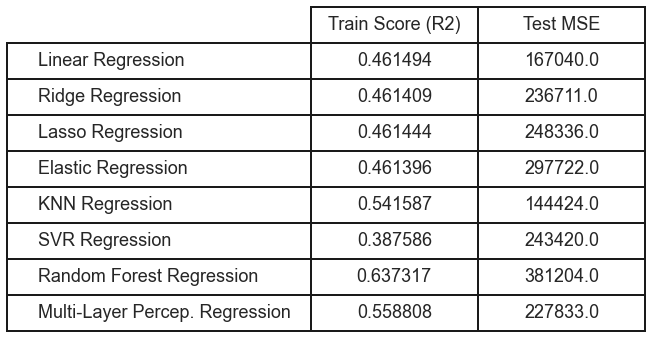

In [411]:
# Generamos una lista con todos nuestros regresores entrenados con GridSearchCV
regresors = [lin_reg, ridge_reg, lasso_reg, elastic_reg,
             knn_reg, svr_reg, rf_reg, mlp_reg]

# Generamos un NumPy Array vacío en el que cargaremos 
# el score de entrenamiento de cada modelo
train_score_col = np.array([])
for reg in regresors:
    train_score_col = np.concatenate( (train_score_col, np.array([reg.best_score_])) )
    
# Generamos un NumPy Array en el que 
# almacenaremos el MSE de test de cada modelo
mse_col = np.array(MSEs)

# Combinamos los dos Numpy Array's creados antes, y transponemos el resultado
# De esta manera nos aseguramos de obtener los registros para las filas de
# nuestra tabla en el formato que necesitamos tenerlo
rows = np.concatenate( ( np.array([train_score_col.round(6)]), 
                        np.array([mse_col.round(0)]) ) ).transpose()

# Creamos las etiquetas de fila de nuestra tabla
row_labels = []
for mdl in modelos:
    lbl = mdl + ' Regression'
    row_labels.append(lbl)


# Configuramos el área de gráfico para que solo veamos la tabla
plt.xticks([])
plt.yticks([])
plt.box(False)

# Creamos nuestra tabla con los datos que hemos preparado más arriba
table = plt.table(cellText= rows,
                  colLabels= ['Train Score (R2)', 'Test MSE'],
                  rowLabels= row_labels,
                  loc= 'center', cellLoc= 'center')

# Configuramos letra de los campos de la tabla
table.set_fontsize(20)
table.scale(1,3)

plt.savefig('graphics/tabla_comparativa_modelos.png', bbox_inches='tight')
plt.show()

Como podemos ver en la tabla, tal como dijimos antes, el modelo que presenta el **mejor score en train es Random Forest, pero es también es el que presenta el mayor valor de MSE durante el test**. Esto lo podemos interpretar como que **el modelo está sobre-ajustando, por lo que habría que probar con otra parametrización para tratar de regularizar**.

Por el contrario, el modelo que presenta el **mejor MSE en test es el KNN Regressor**. Este modelo **también presenta un score de los mejores durante el train**. Podemos decir que, si bien el modelo dista de ser bueno ya que presenta un MSE considerable, parece generalizar lo bastante bien.

Por último, es interesante comentar los resultados del **modelo de Regresión Lineal**, ya que resultó ser el **mejor modelo dentro de los lineales en la fase de train, y también consiguió un MSE de los mejores en la fase de test**. Podemos decir que **se trata de un modelo simple, con un costo computacional relativamente bajo, que presenta resultados aceptables para nuestro caso**.

# CONCLUSIÓN

Como hemos aprendido en clase, los modelos de regresión no suelen dar tan buenos resultados como los de clasificación. Como podemos ver, este caso no es la excepción. Ninguno de los modelos ha conseguido generar una predicción que esté alineada con la recta de correspondencia con los valores reales.

Esto se puede deber, o bien a que el caso en estudio es demasiado complejo para los modelos propuestos, o no contamos con suficientes variables / datos informativos para conseguir un mejor resultado.

De tener que optar por uno de los modelos propuestos más arriba, nos quedaremos con **KNN Regressor**, pero lo ideal sería continuar trabajando con los datos y proponer un modelo que pueda abordar mejor el problema, como puede serlo quizás una Red Neuronal con mayor configuración de capas, neuronas, funciones activadoras, etc.